In [ ]:
# install.packages('visdat')
# install.packages('corrgram')
library(visdat)
library(dplyr)

# Exploratory Data Analysis

In [2]:
# Import data
data <- read.csv("data_model.csv")

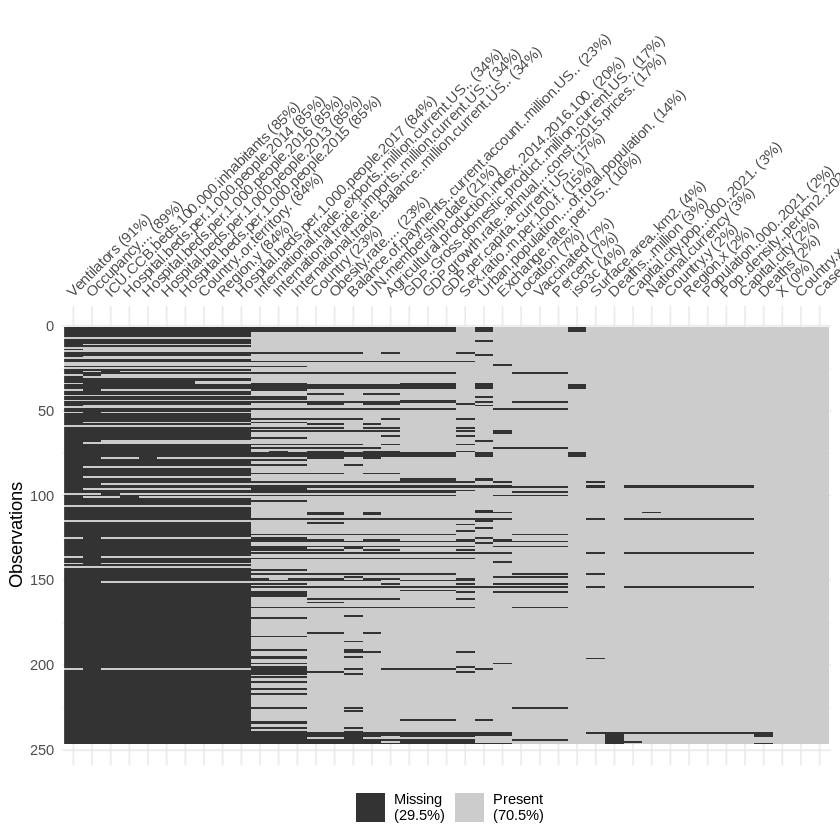

In [3]:
# Viss_miss chart to show variable missingess
visdat::vis_miss(data, sort_miss = TRUE)

In [4]:
# Calculate the percentage of missing values for each variable
missing_percentages <- sapply(data, function(col) mean(is.na(col)) * 100)

# Identify variables with less than 50% missing values
keep_variables <- names(missing_percentages[missing_percentages < 50])

# Subset the data to keep only those variables
filtered_data <- data[, keep_variables]

In [5]:
str(filtered_data)

'data.frame':	246 obs. of  31 variables:
 $ X                                                 : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Country.x                                         : chr  "World" "World" "World" "Peru" ...
 $ Deaths...million                                  : chr  "872" "872" "872" "6,511" ...
 $ Deaths                                            : chr  "6,960,770" "6,960,770" "6,960,770" "221,704" ...
 $ Cases                                             : chr  "771,150,460" "771,150,460" "771,150,460" "4,520,727" ...
 $ iso3c                                             : chr  NA NA NA "PER" ...
 $ Country.y                                         : chr  "Channel Islands" "Channel Islands" "Channel Islands" "Peru" ...
 $ Region.x                                          : chr  "Northern Europe" "Northern Europe" "Northern Europe" "South America" ...
 $ Population..000..2021.                            : int  175 175 175 33359 6897 3264 9634 2083 3980 4082 ...
 $ Pop..den

In [6]:
# Remove rows with NA values in iso3c column
filtered_data <- filtered_data %>% filter(!is.na(iso3c))

We want to use iso3c as a primary key. We will check for uniqueness of iso3c variable

In [7]:
# Check for uniqueness of iso3c to ensure it can act as a primary key
if (nrow(filtered_data) == length(unique(filtered_data$iso3c))) {
  message("iso3c can act as a primary key!")
} else {
  message("iso3c has duplicate values and cannot act as a primary key.")
}

iso3c has duplicate values and cannot act as a primary key.



In [8]:
# Find duplicated rows based on the iso3c column
duplicated_rows <- filtered_data[duplicated(filtered_data$iso3c) |
                                       duplicated(filtered_data$iso3c, fromLast = TRUE), ]

# View duplicated value
duplicated_iso3c <- unique(duplicated_rows$iso3c)
print(duplicated_iso3c)

[1] "CYP"


After examining, CYP (Cyprus) represents both Cyprus Nothern Cyprus. Since Nothern Cyprus is recognised as a part of the Republic of Cyprus (https://en.wikipedia.org/wiki/Northern_Cyprus#cite_note-8), we will not include Nothern Cyprus in our data, as values in Northern Cyprus data appears to be duplicated from Cyrpus data values.

In [9]:
filtered_data <- filtered_data %>% filter(Location != "Northern Cyprus")

In [10]:
# Recheck if iso3c can be used as primary key
if (nrow(filtered_data) == length(unique(filtered_data$iso3c))) {
  message("iso3c can act as a primary key!")
} else {
  message("iso3c has duplicate values and cannot act as a primary key.")
}

iso3c can act as a primary key!



In [11]:
str(filtered_data)

'data.frame':	218 obs. of  31 variables:
 $ X                                                 : int  4 5 6 7 8 9 10 11 12 13 ...
 $ Country.x                                         : chr  "Peru" "Bulgaria" "Bosnia and Herzegovina" "Hungary" ...
 $ Deaths...million                                  : chr  "6,511" "5,664" "5,057" "4,896" ...
 $ Deaths                                            : chr  "221,704" "38,414" "16,354" "48,807" ...
 $ Cases                                             : chr  "4,520,727" "1,302,188" "403,155" "2,206,311" ...
 $ iso3c                                             : chr  "PER" "BGR" "BIH" "HUN" ...
 $ Country.y                                         : chr  "Peru" "Bulgaria" "Bosnia and Herzegovina" "Hungary" ...
 $ Region.x                                          : chr  "South America" "Eastern Europe" "Southern Europe" "Eastern Europe" ...
 $ Population..000..2021.                            : int  33359 6897 3264 9634 2083 3980 4082 2079 628 10725

Next, we will convert variables to appropriate data type

In [12]:
# Convert columns with numbers in string format containing commas to integers
cols_with_commas <- c('Deaths...million', 'Deaths', 'Cases', 'Vaccinated')
for (col in cols_with_commas) {
  if (col %in% colnames(filtered_data)) {
    filtered_data[[col]] <- as.numeric(gsub(",", "", filtered_data[[col]]))
  }
}

# Convert to numeric columns
cols_with_decimals <- c('Pop..density..per.km2..2021.','Surface.area..km2.', 'Sex.ratio..m.per.100.f.', 'Exchange.rate..per.US..',
                        'GDP.growth.rate..annual....const..2015.prices.', 'GDP.per.capita..current.US..',
                        'Urban.population....of.total.population.', 'Obesity.rate....', 'Percent')

for (col in cols_with_decimals) {
  if (col %in% colnames(filtered_data)) {
    filtered_data[[col]] <- as.numeric(filtered_data[[col]])
  }
}

# Check the structure of the data after conversion
str(filtered_data)

'data.frame':	218 obs. of  31 variables:
 $ X                                                 : int  4 5 6 7 8 9 10 11 12 13 ...
 $ Country.x                                         : chr  "Peru" "Bulgaria" "Bosnia and Herzegovina" "Hungary" ...
 $ Deaths...million                                  : num  6511 5664 5057 4896 4750 ...
 $ Deaths                                            : num  221704 38414 16354 48807 9946 ...
 $ Cases                                             : num  4520727 1302188 403155 2206311 349104 ...
 $ iso3c                                             : chr  "PER" "BGR" "BIH" "HUN" ...
 $ Country.y                                         : chr  "Peru" "Bulgaria" "Bosnia and Herzegovina" "Hungary" ...
 $ Region.x                                          : chr  "South America" "Eastern Europe" "Southern Europe" "Eastern Europe" ...
 $ Population..000..2021.                            : int  33359 6897 3264 9634 2083 3980 4082 2079 628 10725 ...
 $ Pop..density..

In [13]:
# Remove X column as we will use iso3c as primary key and also removing redunant country columns
filtered_data <- filtered_data %>%
  select(-X, -Country.y, -Country, -Location)

str(filtered_data)

'data.frame':	218 obs. of  27 variables:
 $ Country.x                                         : chr  "Peru" "Bulgaria" "Bosnia and Herzegovina" "Hungary" ...
 $ Deaths...million                                  : num  6511 5664 5057 4896 4750 ...
 $ Deaths                                            : num  221704 38414 16354 48807 9946 ...
 $ Cases                                             : num  4520727 1302188 403155 2206311 349104 ...
 $ iso3c                                             : chr  "PER" "BGR" "BIH" "HUN" ...
 $ Region.x                                          : chr  "South America" "Eastern Europe" "Southern Europe" "Eastern Europe" ...
 $ Population..000..2021.                            : int  33359 6897 3264 9634 2083 3980 4082 2079 628 10725 ...
 $ Pop..density..per.km2..2021.                      : num  26.1 63.5 64 106.4 82.6 ...
 $ Capital.city                                      : chr  "Lima" "Sofia" "Sarajevo" "Budapest" ...
 $ Capital.city.pop...000..2021. 

In [14]:
# Renaming columns

names(filtered_data) <- c('Country', 'Deaths_per_Million', 'Deaths', 'Cases', 'iso3c', 'Region', 'Population-000-2021', 'Pop-density-per-km2-2021',
                          'Capital-city', 'Capital-city-pop000-2021', 'UN-membership-date', 'Surface-area-km2', 'Sex-ratio-m-per-100-f', 'National-currency',
                          'Exchange-rate-per-us', 'GDP-million-US', 'GDP-growth-rate-annual-const', 'GDP-per-capita-current-US', 'Agricultural-production-index',
                          'International-trade-exports-million-current-US', 'International-trade-imports-million-current-US', 'International-trade-balance-million-current-US',
                          'Balance-of-payments-current-million-US', 'Urban-population-of-total-population', 'Obesity-rate', 'Vaccinated', 'Percent')

str(filtered_data)

'data.frame':	218 obs. of  27 variables:
 $ Country                                       : chr  "Peru" "Bulgaria" "Bosnia and Herzegovina" "Hungary" ...
 $ Deaths_per_Million                            : num  6511 5664 5057 4896 4750 ...
 $ Deaths                                        : num  221704 38414 16354 48807 9946 ...
 $ Cases                                         : num  4520727 1302188 403155 2206311 349104 ...
 $ iso3c                                         : chr  "PER" "BGR" "BIH" "HUN" ...
 $ Region                                        : chr  "South America" "Eastern Europe" "Southern Europe" "Eastern Europe" ...
 $ Population-000-2021                           : int  33359 6897 3264 9634 2083 3980 4082 2079 628 10725 ...
 $ Pop-density-per-km2-2021                      : num  26.1 63.5 64 106.4 82.6 ...
 $ Capital-city                                  : chr  "Lima" "Sofia" "Sarajevo" "Budapest" ...
 $ Capital-city-pop000-2021                      : num  10555 1277 34

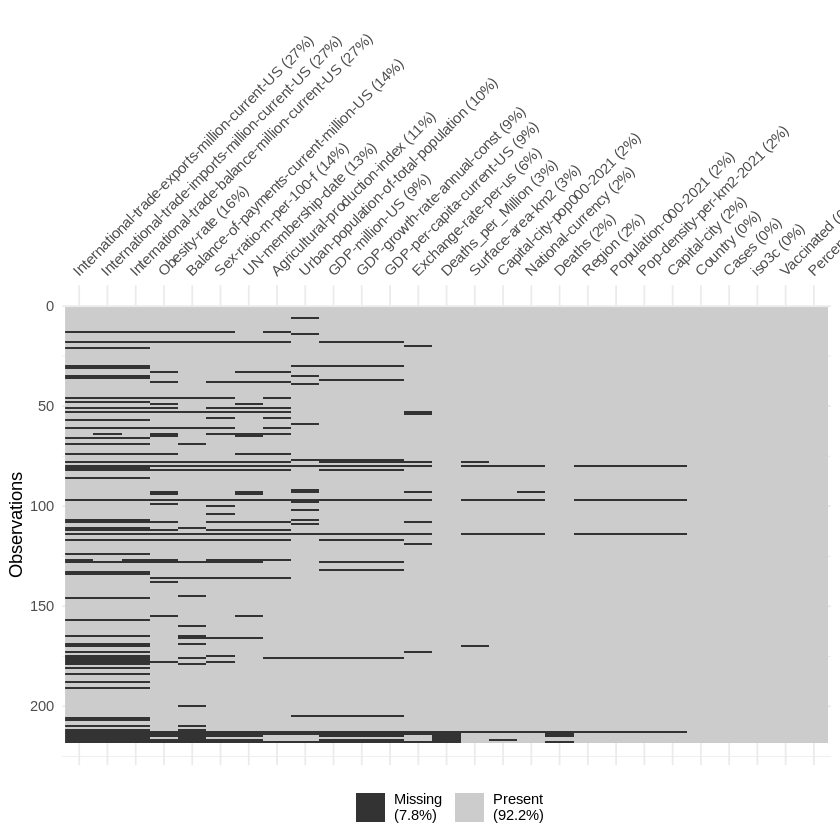

In [15]:
# Viss_miss chart to show variable missingess
visdat::vis_miss(filtered_data, sort_miss = TRUE)

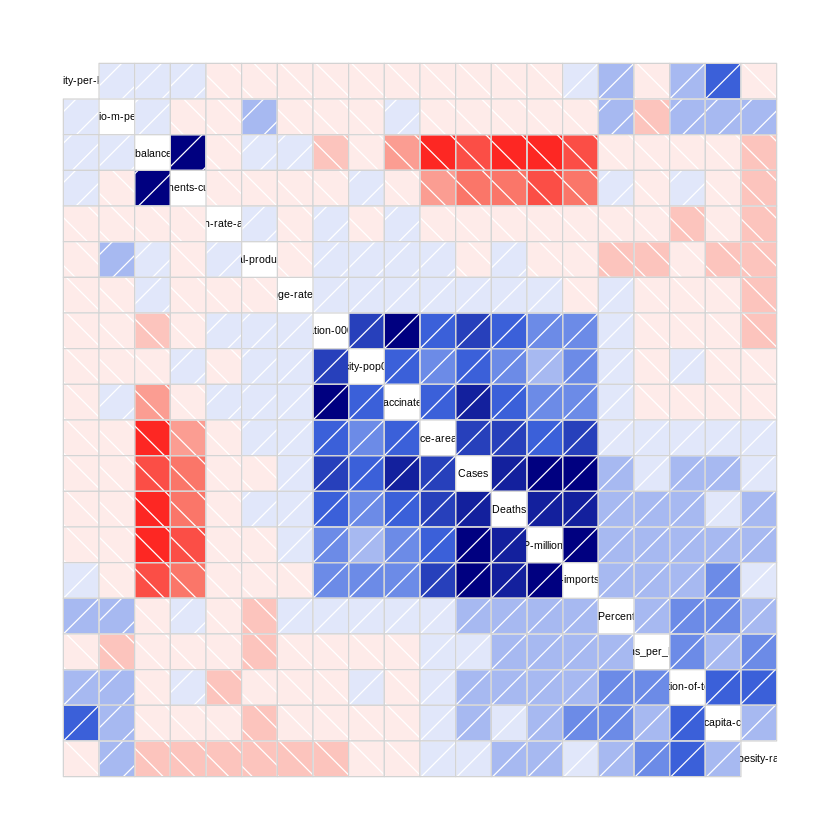

In [16]:
corrgram::corrgram(filtered_data,
                   order = TRUE, # TRUE or FALSE
                   abs = FALSE, # TRUE or FALSE
                   cor.method = "pearson" # pearson, spearman, kendall
                  )

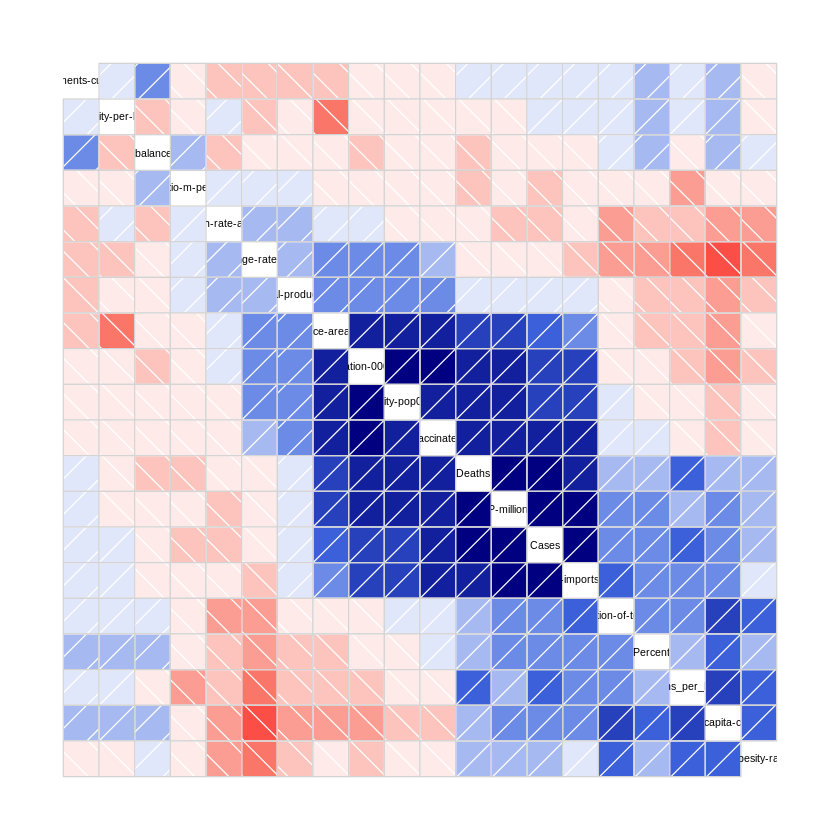

In [17]:
corrgram::corrgram(filtered_data,
                   order = TRUE, # TRUE or FALSE
                   abs = FALSE, # TRUE or FALSE
                   cor.method = "spearman" # pearson, spearman, kendall
                  )

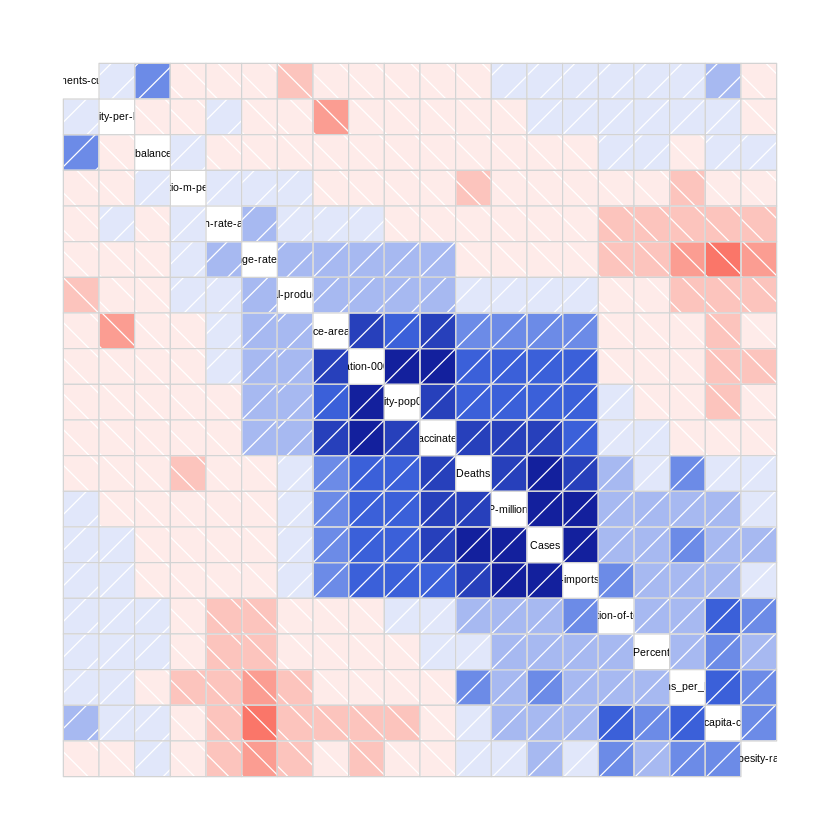

In [18]:
corrgram::corrgram(filtered_data,
                   order = TRUE, # TRUE or FALSE
                   abs = FALSE, # TRUE or FALSE
                   cor.method = "kendall" # pearson, spearman, kendall
                  )

In [19]:
# Export cleaned csv file
write.csv(filtered_data,"Cleaned_data.csv", row.names=FALSE)

# Correlation and variable missingess discussion

Looking at the corrgrams, there are 2 noticeable highly correlated groups in Pearson correlation method:


**Group 1:**
+ International.trade.balance.million.current.US
+ Balance.of.payments.current.million.US

**Group 2**
+ Population-000-2021
+ Capital-city-pop-000-2021
+ Vaccinated
+ Surface-area-km2
+ Cases
+ Deaths
+ GDP.million.US
+ International.trade.imports.million.current.US

Group 1 variables appear to be strongly correlated with each other, while strongly negatively correlated to group 2 variables.

In the other 2 correlation method, the strong negative correlation between group 1 and group 2 variables are not as visible.
Considering group 1 variables have higher missingess (27% and 14% respectively), if we are interested in these variables, missingness will need to be handled beforehand. The gap in data could introduce bias in our analysis.
Group 2 variables have low missingess, which data would be more available and reliable for analysis.

